In [49]:
from scipy.stats import invgamma
from scipy.stats import norm
from multiprocessing import Pool
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [69]:
def integral(estimate, ts):
    elements = np.ones(len(ts) - 1)
    for i in range(len(ts) - 1):
        elements[i] = (ts[i+1] - ts[i])*(estimate[i+1] + estimate[i])/2
    return sum(elements)

def sum1(beta):
    elements = np.ones(N)
    for i in range(N):
        elements[i] = p[i, 0] - beta * (p[i, 1] - ave_x)
    return np.sum(elements)

def sum2(alpha):
    elements = np.ones(N)
    for i in range(N):
        elements[i] = (p[i, 1] - ave_x)*(p[i, 0] - alpha)
    return np.sum(elements)

def sum3(alpha, beta):
    elements = np.ones(N)
    for i in range(N):
        elements[i] = (p[i, 0] - alpha - beta*(p[i, 1] - ave_x))**2
    return np.sum(elements)

def loglike(alpha, beta, sigma):
    return N*np.log(1/(np.sqrt(2*np.pi*sigma))) - sum3(alpha, beta) / (2*sigma)

def function1(w):
    if w < m:
        np.random.seed(datetime.now().microsecond)
        estimates = np.ones(n+1)

        for i in range(n+1):
            t = ts[i]

            alphas = np.ones(sample_iter)
            betas = np.ones(sample_iter)
            sigmas = np.ones(sample_iter)
            
            if i == 0:
                alphas[0] = 3000
                betas[0] = 185
                sigmas[0] = 90000

            else:
                alphas[0] = np.mean(alpha_sample)
                betas[0] = np.mean(beta_sample)
                sigmas[0] = np.mean(sigma_sample)

            for j in range(sample_iter -1):

                location_alpha = (sigma_alpha*t*sum1(betas[-1]) + sigmas[-1]*mu_alpha) / (sigma_alpha * N*t + sigmas[-1])
                scale_alpha = np.sqrt((sigma_alpha * sigmas[-1]) / (sigma_alpha * N*t + sigmas[-1]))
                alphas[j+1] = norm.rvs(loc = location_alpha, scale = scale_alpha)

                location_beta = (sigma_beta * t * sum2(alphas[-1]) + sigmas[-1] * mu_beta) / (sigma_beta *t* var*N + sigmas[-1])
                scale_beta = np.sqrt((sigmas[-1] * sigma_beta) / (sigma_beta *t* var*N + sigmas[-1]))
                betas[j+1] = norm.rvs(loc = location_beta, scale = scale_beta)

                shape = N*t/2 + a
                invrate = 2*b / (b*t*sum3(alphas[-1], betas[-1]) + 2)
                sigmas[j+1] = invgamma.rvs(a = shape, scale = 1/ invrate)

            alpha_sample = alphas[burn_in:]
            beta_sample = betas[burn_in:len(betas)]
            sigma_sample = sigmas[burn_in:len(sigmas)]

            box = np.ones(len(alpha_sample))
            for k, l in enumerate(alpha_sample):
                box[k] = loglike(l, beta_sample[k], sigma_sample[k])

            estimates[i] = np.average(box)
        
        return estimates
    
def sum4(beta):
    elements = np.ones(N)
    for i in range(N):
        elements[i] = p[i, 0] - beta * (p[i, 2] - ave_z)
    return np.sum(elements)

def sum5(alpha):
    elements = np.ones(N)
    for i in range(N):
        elements[i] = (p[i, 2] - ave_z)*(p[i, 0] - alpha)
    return np.sum(elements)

def sum6(alpha, beta):
    elements = np.ones(N)
    for i in range(N):
        elements[i] = (p[i, 0] - alpha - beta*(p[i, 2] - ave_z))**2
    return np.sum(elements)    

def loglike2(alpha, beta, sigma):
    return N*np.log(1/(np.sqrt(2*np.pi*sigma))) - sum6(alpha, beta) / (2*sigma)
    
def function2(w):
    if w < m:
        np.random.seed(datetime.now().microsecond)
        estimates = np.ones(n+1)

        for i in range(n+1):
            t = ts[i]

            gammas = np.ones(sample_iter)
            deltas = np.ones(sample_iter)
            taus = np.ones(sample_iter)
            
            if i == 0:
                gammas[0] = 3000
                deltas[0] = 185
                taus[0] = 90000

            else:
                gammas[0] = np.mean(gamma_sample)
                deltas[0] = np.mean(delta_sample)
                taus[0] = np.mean(tau_sample)

            for j in range(sample_iter - 1):

                location_alpha = (sigma_alpha*t*sum4(deltas[-1]) + taus[-1]*mu_alpha) / (sigma_alpha * N*t + taus[-1])
                scale_alpha = np.sqrt((sigma_alpha * taus[-1]) / (sigma_alpha * N*t + taus[-1]))
                gammas[j+1] = norm.rvs(loc = location_alpha, scale = scale_alpha)

                location_beta = (sigma_beta * t * sum5(gammas[-1]) + taus[-1] * mu_beta) / (sigma_beta *t* var2*N + taus[-1])
                scale_beta = np.sqrt((taus[-1] * sigma_beta) / (sigma_beta *t* var2*N + taus[-1]))
                deltas[j+1] = norm.rvs(loc = location_beta, scale = scale_beta)

                shape = N*t/2 + a
                invrate = 2*b / (b*t*sum6(gammas[-1], deltas[-1]) + 2)
                taus[j+1] = invgamma.rvs(a = shape, scale = 1/ invrate)

            gamma_sample = gammas[burn_in:]
            delta_sample = deltas[burn_in:len(deltas)]
            tau_sample = taus[burn_in:len(taus)]

            box2 = np.ones(len(gamma_sample))
            for k, l in enumerate(gamma_sample):
                box2[k] = loglike2(l, delta_sample[k], tau_sample[k])

            estimates[i] = np.average(box2)
        
        return estimates

In [51]:
pine = pd.read_table("pine.txt", delim_whitespace = True)
p = pine.values
ave_x = np.average(p[:, 1]).item()
ave_z = np.average(p[:, 2]).item()

mu_alpha = 3000
sigma_alpha = 10**6
mu_beta = 185
sigma_beta = 10**4
a = 3
b = 1/(2*300**2)

N = np.shape(p)[0]
var = np.var(p[:, 1])
var2 = np.var(p[:, 2])

n = 10
c = 2
ts = [(i/n)**c for i in range(n+1)]

# ここをいじってね。
sample_iter = 1000
burn_in = 30
m = 10
core = 2


収束の確認

In [32]:
# model 1

n = 10
c = 2
######

estimates = np.ones(n+1)
ts = np.ones(n+1)


t = (1/n)**c


alphas = np.ones(sample_iter)
betas = np.ones(sample_iter)
sigmas = np.ones(sample_iter)


alphas[0] = 3000
betas[0] = 185
sigmas[0] = 90000


for j in range(sample_iter -1):

    location_alpha = (sigma_alpha*t*sum1(betas[-1]) + sigmas[-1]*mu_alpha) / (sigma_alpha * N*t + sigmas[-1])
    scale_alpha = np.sqrt((sigma_alpha * sigmas[-1]) / (sigma_alpha * N*t + sigmas[-1]))
    r = norm.rvs(loc = location_alpha, scale = scale_alpha)
    alphas[j+1] = r

    location_beta = (sigma_beta * t * sum2(alphas[-1]) + sigmas[-1] * mu_beta) / (sigma_beta *t* var*N + sigmas[-1])
    scale_beta = np.sqrt((sigmas[-1] * sigma_beta) / (sigma_beta *t* var*N + sigmas[-1]))
    q = norm.rvs(loc = location_beta, scale = scale_beta)
    betas[j+1] = q

    shape = N*t/2 + a
    invrate = 2*b / (b*t*sum3(alphas[-1], betas[-1]) + 2)
    s = invgamma.rvs(a = shape, scale = 1/ invrate)
    sigmas[j+1] = s

<function matplotlib.pyplot.plot>

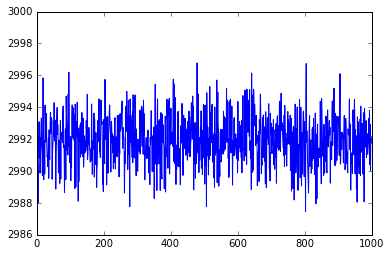

In [33]:
plt.plot(alphas)
plt.plot

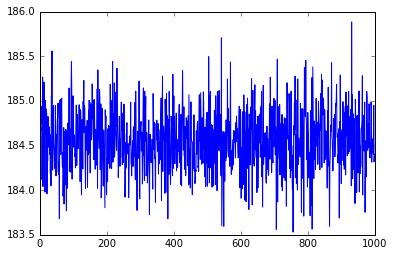

In [34]:
plt.plot(betas)

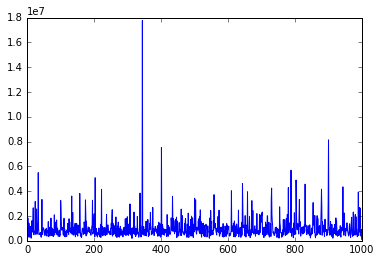

In [35]:
plt.plot( sigmas)

In [36]:
# model 2

n = 10
c = 2
######

estimates = np.ones(n+1)
ts = np.ones(n+1)


t = (1/n)**c


gammas = np.ones(sample_iter)
deltas = np.ones(sample_iter)
taus = np.ones(sample_iter)


gammas[0] = 3000
deltas[0] = 185
taus[0] = 90000

for j in range(sample_iter - 1):

    location_alpha = (sigma_alpha*t*sum4(deltas[-1]) + taus[-1]*mu_alpha) / (sigma_alpha * N*t + taus[-1])
    scale_alpha = np.sqrt((sigma_alpha * taus[-1]) / (sigma_alpha * N*t + taus[-1]))
    r = norm.rvs(loc = location_alpha, scale = scale_alpha)
    gammas[j+1] = r

    location_beta = (sigma_beta * t * sum5(gammas[-1]) + taus[-1] * mu_beta) / (sigma_beta *t* var2*N + taus[-1])
    scale_beta = np.sqrt((taus[-1] * sigma_beta) / (sigma_beta *t* var2*N + taus[-1]))
    q = norm.rvs(loc = location_beta, scale = scale_beta)
    deltas[j+1] = q

    shape = N*t/2 + a
    invrate = 2*b / (b*t*sum6(gammas[-1], deltas[-1]) + 2)
    s = invgamma.rvs(a = shape, scale = 1/ invrate)
    taus[j+1] = s

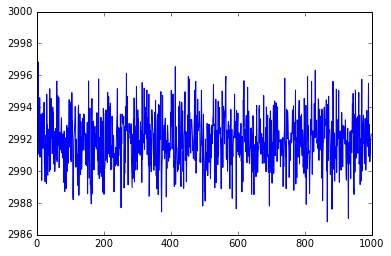

In [37]:
plt.plot(gammas)

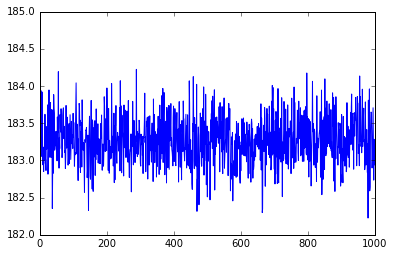

In [38]:
plt.plot(deltas)

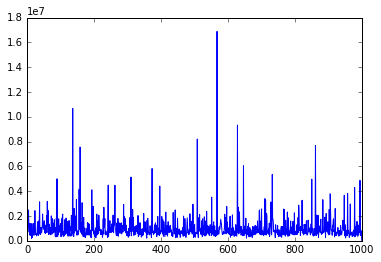

In [39]:
plt.plot(taus)

# computing BF


model1

In [52]:
if __name__ == '__main__':
    p = Pool(core) 
    result1 = p.map(function1, range(m))

In [53]:
result1

[array([-745.09790175, -327.81812579, -349.09234194, -359.59492345,
        -365.38160874, -368.59765074, -370.6616598 , -371.85394871,
        -373.01744497, -373.98052291, -374.20946219]),
 array([-772.97547865, -327.63456684, -349.1164643 , -359.92738528,
        -365.02784156, -368.83046518, -370.60831445, -372.33794447,
        -373.30495407, -373.92127396, -374.2575189 ]),
 array([-737.81854715, -327.13618265, -348.28779191, -359.73765175,
        -365.5420989 , -368.67369539, -370.65917733, -372.08840987,
        -373.22957133, -373.67768635, -374.25465134]),
 array([-714.52613036, -328.52999715, -349.18009519, -358.77845155,
        -365.29524246, -368.95013056, -370.69391441, -372.19888701,
        -373.02950716, -373.96405341, -374.11194741]),
 array([-719.1970649 , -328.4115183 , -348.77872022, -359.25528462,
        -364.92673095, -368.57781716, -370.71406152, -371.98090346,
        -373.10160127, -373.64069078, -374.50957835]),
 array([-657.48044988, -327.69916385, -349.07

In [64]:
expect1 = np.ones(10)
for i in range(10):
    expect1[i] = integral(result1[i], ts)

In [55]:
expect1

array([-370.9996711 , -371.25254048, -370.96271011, -370.88577362,
       -370.81560612, -370.5943237 , -371.11167398, -370.76968476,
       -370.97764113, -370.9683769 ])

model2

In [56]:
if __name__ == '__main__':
    result2 = p.map(function2, range(m))

In [57]:
expect2 = np.ones(10)
for i in range(10):
    expect2[i] = integral(result2[i], ts)

In [58]:
expect2

array([-370.66155375, -370.46336308, -370.89767643, -370.96686296,
       -370.82816781, -370.92802044, -370.96960512, -370.77104723,
       -370.49511143, -370.67660515])

BF21

In [59]:
bf_21 = []
for a,b in zip(expect1, expect2):
    bf_21.append(np.exp(b-a))

In [60]:
bf_21

[1.4023050643924386,
 2.2015846568974955,
 1.0671949750300593,
 0.92211130989976497,
 0.98751688030357154,
 0.71627096023196413,
 1.1526560109275217,
 0.99863846448330051,
 1.6201677500531442,
 1.3387974134647829]